In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import warnings
import seaborn as sns
import time
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer


from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier



In [75]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

full = pd.concat([train,test])

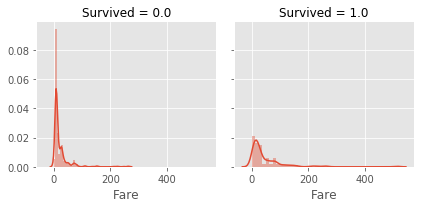

In [3]:
g = sns.FacetGrid(data = full,col = "Survived")
g.map(sns.distplot, "Fare")

In [4]:
pd.cut(train[train.Survived==1.0].Age,20).value_counts().sort_index()

(0.34, 4.399]       27
(4.399, 8.378]       9
(8.378, 12.357]      4
(12.357, 16.336]    15
(16.336, 20.315]    27
(20.315, 24.294]    36
(24.294, 28.273]    30
(28.273, 32.252]    35
(32.252, 36.231]    35
(36.231, 40.21]     17
(40.21, 44.189]     12
(44.189, 48.168]    12
(48.168, 52.147]    14
(52.147, 56.126]     7
(56.126, 60.105]     5
(60.105, 64.084]     4
(64.084, 68.063]     0
(68.063, 72.042]     0
(72.042, 76.021]     0
(76.021, 80.0]       1
Name: Age, dtype: int64

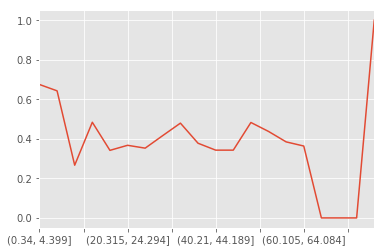

In [5]:
(pd.cut(train[train.Survived==1.0].Age,20).value_counts().sort_index()/pd.cut(train.Age,20).value_counts().sort_index()).plot()

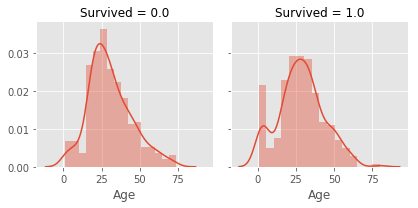

In [6]:
g = sns.FacetGrid(data = full,col = "Survived")
g.map(sns.distplot, "Age")

In [7]:
def parse(name):
    name = name.split(',')
    title = name[1].split('.')
    title = title[0].strip()
    if title in ["Jonkheer","Don", "Sir", "the Countess","Dona","Lady"]:
        return 'Loyalty'
    elif title in ["Capt","Col","Major","Dr","Rev"]:
        return "Officer"
    elif title in ["Mme","Ms"]:
        return "Mrs"
    elif title in ["Mlle"]:
        return "Miss"
    else:
        return title


In [8]:
full["Name"] = full.Name.map(parse)

In [9]:
full.groupby(["Pclass","Sex"]).Age.agg(['mean','median','count'])

mean  median  count
Pclass Sex                             
1      female  37.037594    36.0    133
       male    41.029272    42.0    151
2      female  27.499223    28.0    103
       male    30.815380    29.5    158
3      female  22.185329    22.0    152
       male    25.962264    25.0    349

In [10]:
full["Age"] = full.groupby(["Pclass","Sex"]).Age.transform(lambda x:x.fillna(x.median()))

In [11]:
full.Embarked = full.Embarked.fillna('S')

In [12]:
full["Fare"] = full.Fare.fillna(full.Fare.median())

In [13]:
full = full.drop("Cabin", axis = 1)
full = full.drop("PassengerId", axis = 1)

In [14]:
full = full.drop("Ticket", axis = 1)

In [15]:
def ifkid(age):
    if age < 8:
        return 1
    else:
        return 0
kid = pd.DataFrame({"Kid":full.Age.map(ifkid)})
full = pd.concat([full,kid],axis = 1)

In [16]:
full.head()

,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Kid
0,22.0,S,7.2500,Mr,0,3,male,1,0.0,0
1,38.0,C,71.2833,Mrs,0,1,female,1,1.0,0
2,26.0,S,7.9250,Miss,0,3,female,0,1.0,0
3,35.0,S,53.1000,Mrs,0,1,female,1,1.0,0
4,35.0,S,8.0500,Mr,0,3,male,0,0.0,0


In [17]:
full.Parch.sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 9])

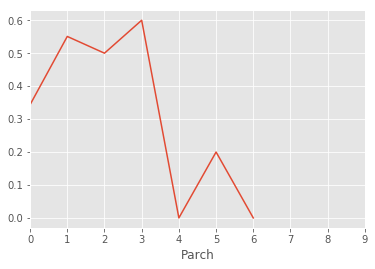

In [18]:
(full.groupby(["Parch"]).sum().Survived/full.groupby(["Parch"]).count().Survived).plot.line()

In [19]:
full.SibSp.sort_values().unique()

array([0, 1, 2, 3, 4, 5, 8])

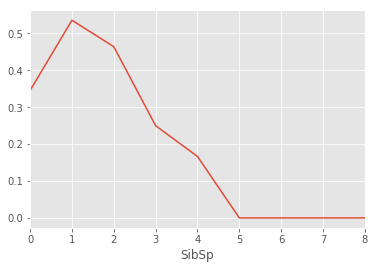

In [20]:
(full.groupby(["SibSp"]).sum().Survived/full.groupby(["SibSp"]).count().Survived).plot.line()

In [21]:
def map_values():
    full["Sex"] = full.Sex.map({"male":1,"female":0})
    full["Parch"] = full.Parch.map({0:1,
                             1:0,2:0,3:0,
                             4:2,5:2,6:2,9:2})
    full["SibSp"] = full.SibSp.map({0:0,1:0,2:0,
                             3:1,4:1,
                             5:2,8:2})

In [22]:
map_values()

In [23]:
full = full.drop("Survived", axis = 1)

In [24]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [25]:
pipe = Pipeline([
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [26]:
full2 = full.copy()

In [27]:
data_pipe = pipe.fit_transform(full2)

In [28]:
data_pipe.shape

(1309, 16)

In [29]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.Survived


In [30]:
y.shape

(891,)

In [31]:
logit = LogisticRegression()
logit.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

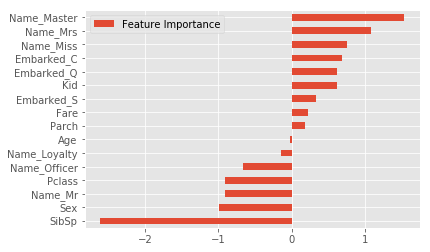

In [32]:
FI_logit = pd.DataFrame(data = {"Feature Importance":logit.coef_[0]},index = data_pipe.columns)
FI_logit.sort_values("Feature Importance", ascending = True).plot(kind = "barh")

In [33]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
  
        X["Miss+Embarked_C"] = X["Name_Miss"] + X["Embarked_C"]
        X["Miss+Embarked_Q"] = X["Name_Miss"] + X["Embarked_Q"]
            
        X["Mrs+Embarked_C"] = X["Name_Mrs"] + X["Embarked_C"]
        X["Kid+Embarked_C"] = X["Kid"] + X["Embarked_C"]
        X["Parch+SibSp"] = X["Parch"] + X["SibSp"]
        X["Pclass+Sex"] = X["Pclass"] + X["Sex"]
        X["-Pclass+Kid"] = - X["Pclass"] + X["Kid"]
        X["Pclass-Embarked_c"] = X["Pclass"] + X["Embarked_C"]
        X["SibSp+Sex"] = X["SibSp"] + X["Sex"]
        
    
        return X

In [34]:
pipe = Pipeline([
    ('skew_dummies1', skew_dummies(skew=1)),
    ('add_feature', add_feature()),
    ('skew_dummies2', skew_dummies(skew=1)),
    ])

In [35]:
full_pipe = pipe.fit_transform(full)

In [36]:
n_train=train.shape[0]

X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.Survived

In [37]:
X.head()

,Age,Fare,Parch,Pclass,Sex,SibSp,Kid,Embarked_C,Embarked_Q,Embarked_S,...,Name_Officer,Miss+Embarked_C,Miss+Embarked_Q,Mrs+Embarked_C,Kid+Embarked_C,Parch+SibSp,Pclass+Sex,-Pclass+Kid,Pclass-Embarked_c,SibSp+Sex
0,22.0,2.110213,1,3,1,0.0,0.0,0.000000,0.0,1,...,0.0,0.000000,0.000000,0.000000,0.000000,0.693147,4,-3.0,3,1.0
1,38.0,4.280593,1,1,0,0.0,0.0,0.693147,0.0,0,...,0.0,0.693147,0.000000,1.098612,0.693147,0.693147,1,-1.0,2,0.0
2,26.0,2.188856,1,3,0,0.0,0.0,0.000000,0.0,1,...,0.0,0.693147,0.693147,0.000000,0.000000,0.693147,3,-3.0,3,0.0
3,35.0,3.990834,1,1,0,0.0,0.0,0.000000,0.0,1,...,0.0,0.000000,0.000000,0.693147,0.000000,0.693147,1,-1.0,1,0.0
4,35.0,2.202765,1,3,1,0.0,0.0,0.000000,0.0,1,...,0.0,0.000000,0.000000,0.000000,0.000000,0.693147,4,-3.0,3,1.0


### RandomForestClassifier

In [80]:
start = time.time()
randomforest = RandomForestClassifier(n_estimators=300)
randomforest.fit(X,y)
print(time.time()-start)

0.3068540096282959


In [45]:
param_test1 = {'max_depth':range(3,14,2), 'min_samples_split':range(20,301,20)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 20, criterion = "gini",
                                                           min_samples_leaf=20,
                                                           random_state=10), 
                        param_grid = param_test1, scoring='accuracy', iid=False,cv=10)
gsearch1.fit(X,y)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_samples_split': 20}, 0.8282479287254569)

In [46]:
param_test2 = {"criterion":["gini","entropy"]}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 20,
                                                          max_depth = 5, min_samples_split = 20,
                                                          random_state = 10),
                       param_grid = param_test2, scoring = "accuracy", iid = False, cv = 10)
gsearch2.fit(X,y)
gsearch2.best_params_, gsearch2.best_score_

({'criterion': 'gini'}, 0.8339288956985585)

## GradientBoostingDecisionTree

In [86]:
start = time.time()
randomforest = GradientBoostingClassifier(n_estimators=300)
randomforest.fit(X,y)
print(time.time()-start)

0.2607841491699219


In [87]:
param_gbdt_0 = {'n_estimators':range(10,201,10)}
gbdt_0 = GridSearchCV(estimator = GradientBoostingClassifier(min_samples_leaf= 20,
                                                           random_state= 10), 
                        param_grid = param_gbdt_0, scoring='roc_auc', iid=False, cv=10)
gbdt_0.fit(X,y)
gbdt_0.best_params_, gbdt_0.best_score_

({'n_estimators': 150}, 0.8781796961208725)

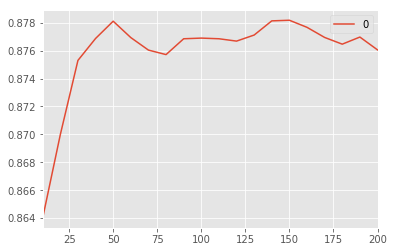

In [88]:
pd.DataFrame(gbdt_0.cv_results_["mean_test_score"],index=range(10,201,10)).plot()

In [41]:
param_gbdt_1 = {'max_depth':range(3,14,2), 'min_samples_split':range(10,101,10)}
gbdt_1 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators = 150,
                                                           min_samples_leaf= 20,
                                                           random_state= 10), 
                        param_grid = param_gbdt_1, scoring='accuracy', iid=False, cv=10)
gbdt_1.fit(X,y)
gbdt_1.best_params_, gbdt_1.best_score_

({'max_depth': 7, 'min_samples_split': 90}, 0.8485362047440699)

In [43]:
param_gbdt_2 = {'max_features':["sqrt","auto","log2"]}
gbdt_2 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators = 150,
                                                             max_depth = 7,
                                                             min_samples_split = 90,
                                                             min_samples_leaf= 20,
                                                             random_state= 10), 
                        param_grid = param_gbdt_2, scoring='accuracy', iid=False, cv=10)
gbdt_2.fit(X,y)
gbdt_2.best_params_, gbdt_2.best_score_

({'max_features': 'auto'}, 0.8485362047440699)

In [69]:
param_gbdt_3 = {'learning_rate':[0.001,0.01,0.1,1,10,100]}
gbdt_3 = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators = 150,
                                                             max_depth = 7,
                                                             min_samples_split = 90,
                                                             min_samples_leaf= 20,
                                                             random_state= 10,
                                                            max_features = 'auto'), 
                        param_grid = param_gbdt_3, scoring='accuracy', iid=False, cv=10)
gbdt_3.fit(X,y)
gbdt_3.best_params_, gbdt_3.best_score_

({'learning_rate': 0.1}, 0.8485362047440699)

## XgBoost

In [ ]:
param_xgb_0 = {'n_estimators':range(10,201,10)}
xgb_0 = GridSearchCV(estimator = XGBClassifier(random_state= 10), 
                        param_grid = param_xgb_0, scoring='roc_auc', iid=False, cv=10)
xgb_0.fit(X,y)
xgb_0.best_params_, xgb_0.best_score_

In [70]:
pred = gbdt_3.predict(test_X)

In [71]:
submission = pd.DataFrame({"PassengerId":test.PassengerId,"Survived":pred})
submission.to_csv("submission.csv", index = False)

## SVC

In [49]:
param_svc_0 = {'C':[0.00001,0.001,0.01,0.1,1,10,100]}
svc_0 = GridSearchCV(estimator = SVC(random_state= 10), 
                        param_grid = param_svc_0, scoring='accuracy', iid=False, cv=10)
svc_0.fit(X,y)
svc_0.best_params_, svc_0.best_score_

({'C': 10}, 0.8283478038815117)

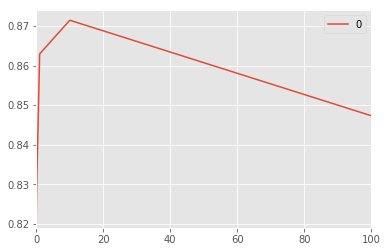

In [39]:
pd.DataFrame(svc_0.cv_results_["mean_test_score"],index=[0.00001,0.001,0.01,0.1,1,10,100]).plot()

In [50]:
param_svc_1 = {'kernel':["poly","rbf","sigmoid"]}
svc_1 = GridSearchCV(estimator = SVC(C = 10), 
                        param_grid = param_svc_1, scoring='accuracy', iid=False, cv=10)
svc_1.fit(X,y)
svc_1.best_params_, svc_0.best_score_

({'kernel': 'rbf'}, 0.8283478038815117)

## Neighbor

In [55]:
param_kn_0 = {'n_neighbors':range(5,101,5),"algorithm":['auto','ball_tree', 'kd_tree', 'brute']}
kn_0 = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid = param_kn_0, scoring='accuracy', iid=False, cv=10)
kn_0.fit(X,y)
kn_0.best_params_, svc_0.best_score_

({'algorithm': 'auto', 'n_neighbors': 5}, 0.8283478038815117)

In [52]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [58]:
stack_model = stacking(mod=[kn_0,svc_0,gsearch2],meta_model=gbdt_3)

In [61]:
a = Imputer().fit_transform(X)
b = Imputer().fit_transform(y.values.reshape(-1,1)).ravel()

In [62]:
stack_model.fit(a,b)

stacking(meta_model=GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=...re_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0),
     mod=[GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=False, n_jobs=None,
       pa...e_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)])

In [65]:
pred = stack_model.predict(test_X)

In [74]:
stack_model.score(a,b)

0.3925798101811906

In [73]:
submission = pd.DataFrame({"PassengerId":test.PassengerId,"Survived":pred})
submission["Survived"] = submission.Survived.map(int)
submission.to_csv("submission.csv", index = False)